## Utilities

In [167]:
!pip install google-api-python-client google-auth-httplib2 google-auth-oauthlib

In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

from google.colab import drive
from google.colab import auth
import gspread
from google.auth import default
from oauth2client.client import GoogleCredentials



In [169]:
# Authenticate user.
auth.authenticate_user()
creds, _ = default()
# Authorize gspread with the obtained credentials
gc = gspread.authorize(creds)

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data extraction

In [170]:
# Load the CSV from the GitHub URL
url = '/content/FINANCE_Credit_Scoring.csv'
df = pd.read_csv(url)

# Display the first few rows of the dataframe
df.head()


,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,...,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,0,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,...,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,1,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,...,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


## EDA

In [171]:
# Get the number of rows and columns
print(df.shape)

(1000, 21)


In [172]:
print(df.columns)

Index(['default', 'account_check_status', 'duration_in_month',
       'credit_history', 'purpose', 'credit_amount', 'savings',
       'present_emp_since', 'installment_as_income_perc',
       'personal_status_sex', 'other_debtors', 'present_res_since', 'property',
       'age', 'other_installment_plans', 'housing', 'credits_this_bank', 'job',
       'people_under_maintenance', 'telephone', 'foreign_worker'],
      dtype='object')


In [173]:
# Data types and missing values
df.info()
# no missing values, good!
print(f"\n {df.isnull().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   default                     1000 non-null   int64 
 1   account_check_status        1000 non-null   object
 2   duration_in_month           1000 non-null   int64 
 3   credit_history              1000 non-null   object
 4   purpose                     1000 non-null   object
 5   credit_amount               1000 non-null   int64 
 6   savings                     1000 non-null   object
 7   present_emp_since           1000 non-null   object
 8   installment_as_income_perc  1000 non-null   int64 
 9   personal_status_sex         1000 non-null   object
 10  other_debtors               1000 non-null   object
 11  present_res_since           1000 non-null   int64 
 12  property                    1000 non-null   object
 13  age                         1000 non-null   int64

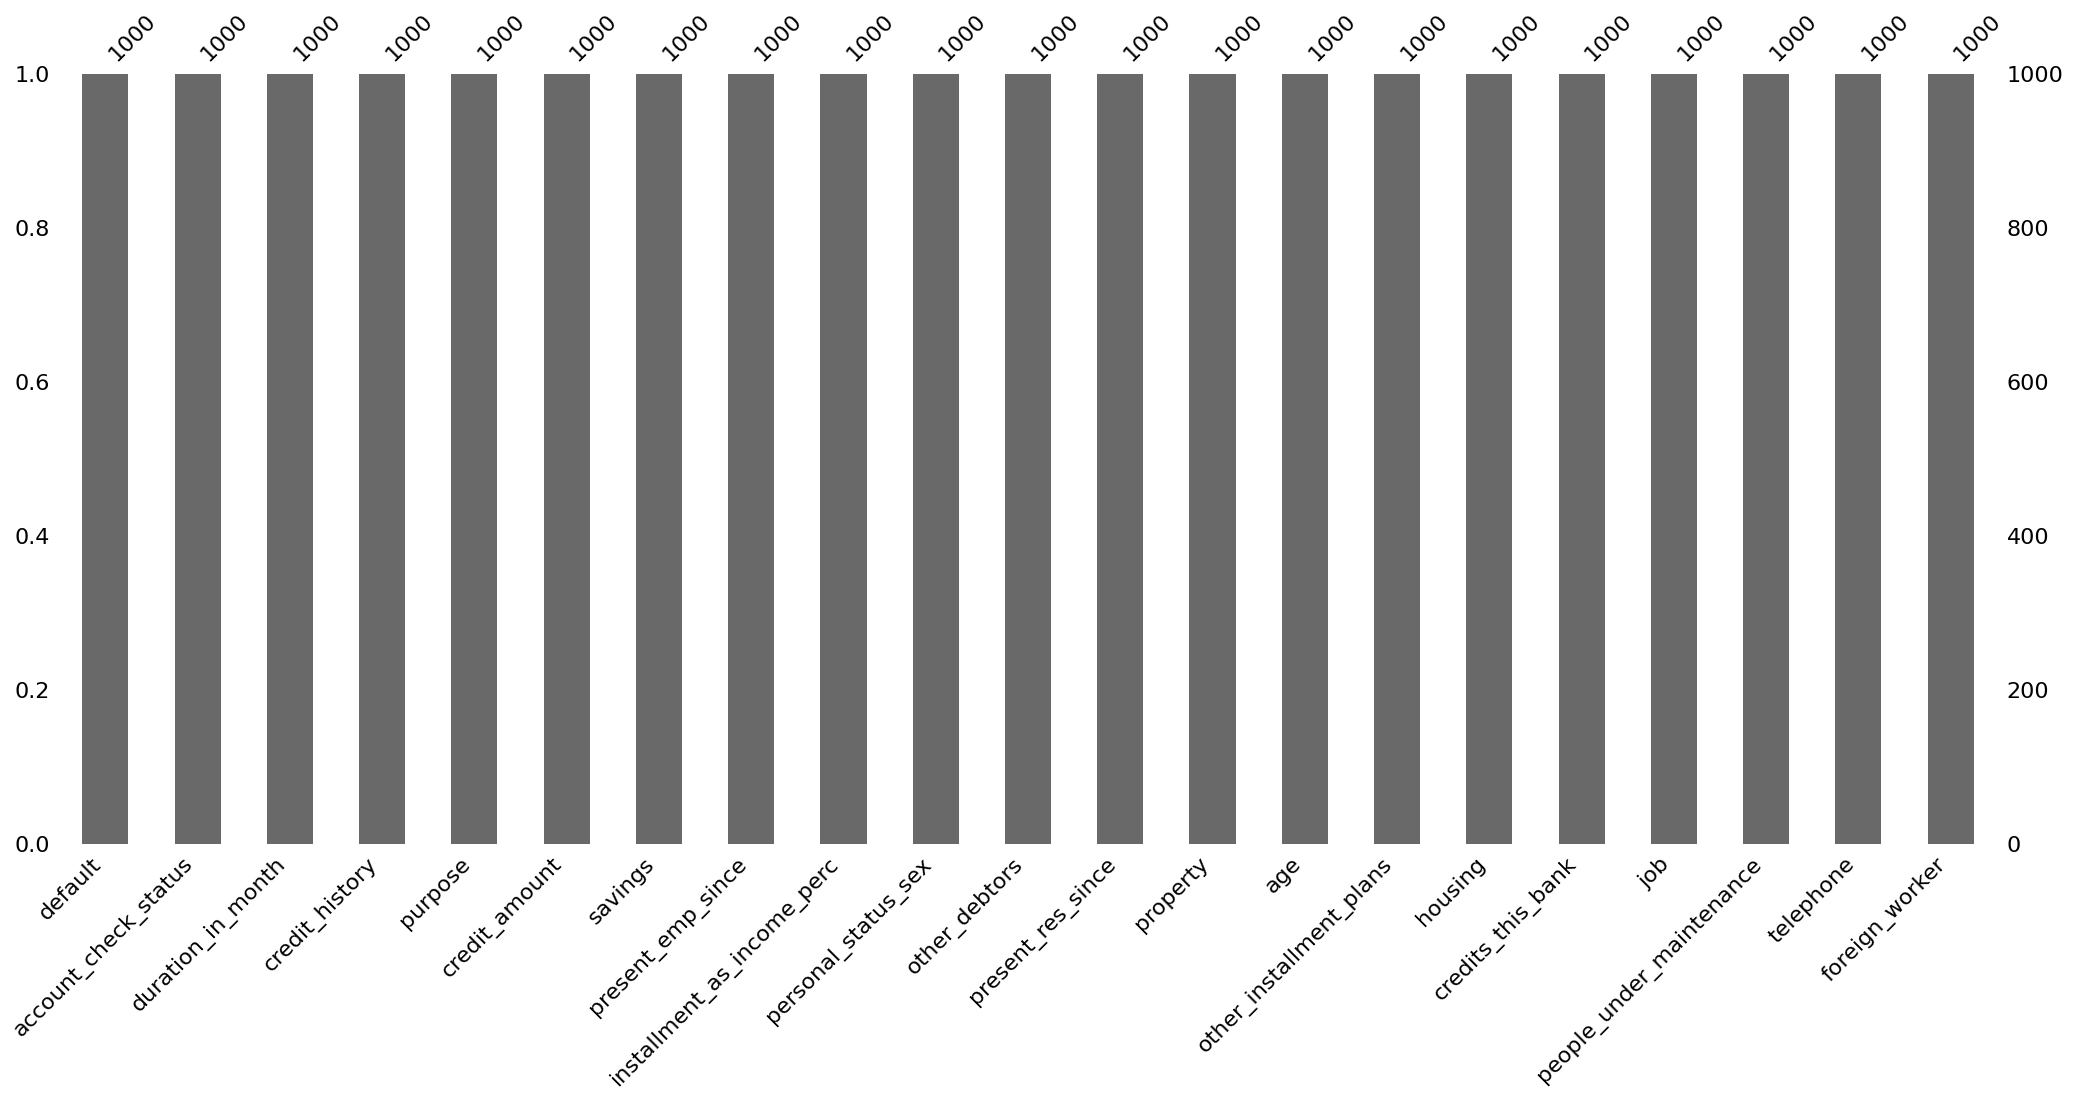

In [174]:
missingno.bar(df)
plt.show()

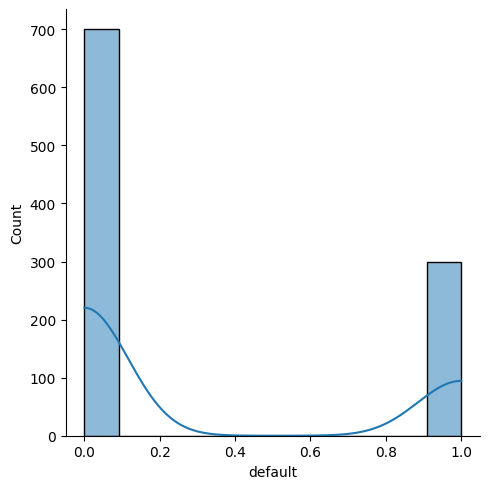

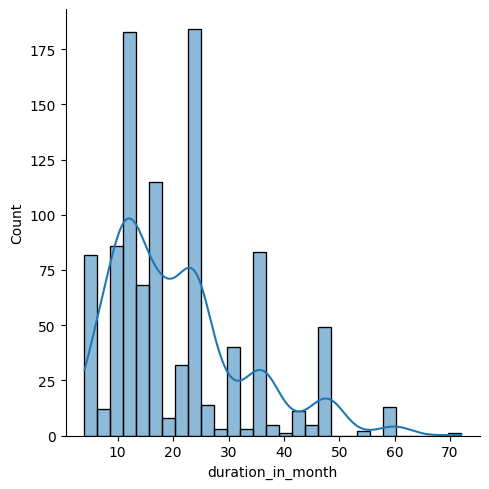

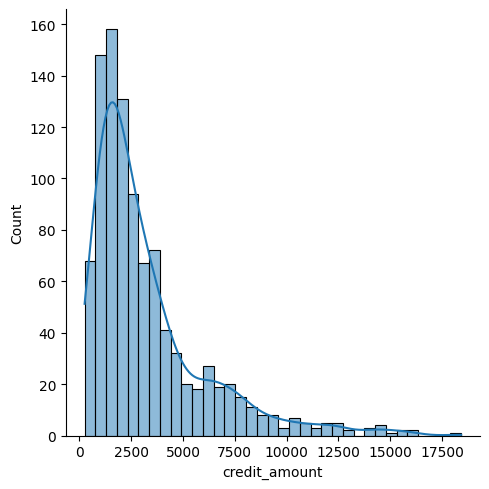

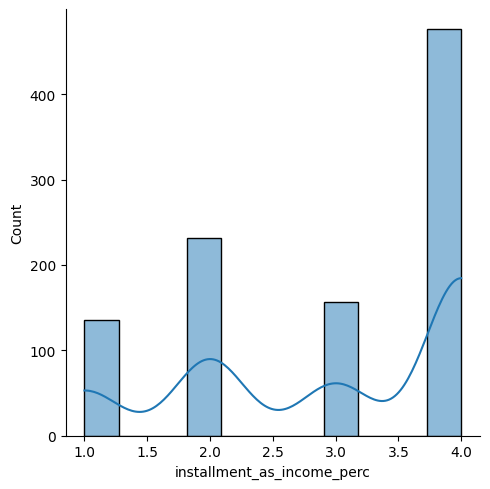

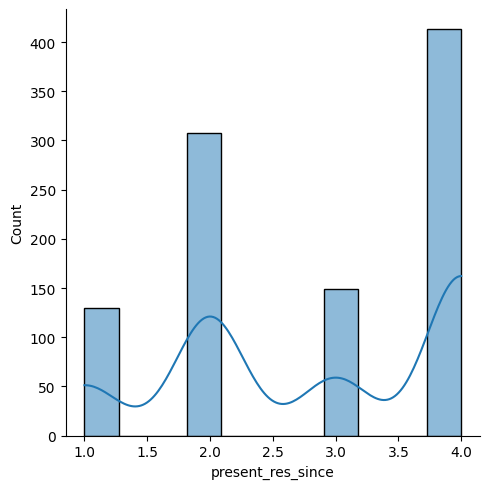

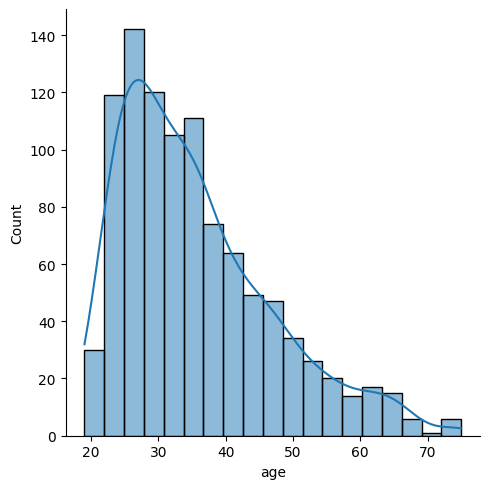

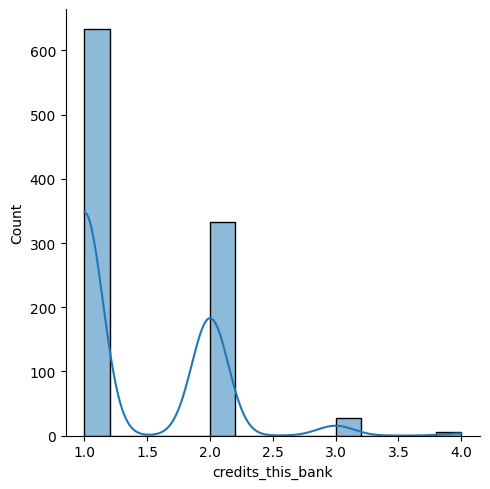

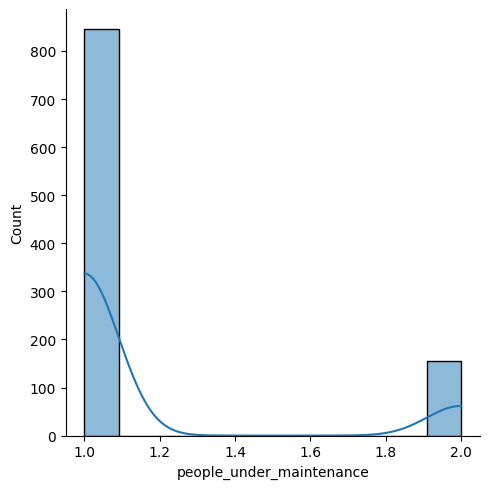

In [175]:
num_cols = df.dtypes[df.dtypes!="O"].index.tolist()
for num_col in num_cols:
    sns.displot(df[num_col], kde=True)
    plt.show()

# doesn't make sense for discrete numerical fetaures, but anyways, kde won't be helpful, but the freq histogram will

In [176]:
df.default.value_counts()
# the person defaulted on their loan (i.e. failed to pay the loan bills) (binary variable)
# is represented as 1 (default) or 0 (no default)
# we have 700 reposnible customers and 300 failing to pay their obligations

,count
default,
0,700
1,300


In [177]:

  # Represents the status of the person's bank account. This could indicate
  # whether the account is in good standing or if there are issues,
  # such as overdrafts or frequent account checks. It may have categories
  # like no known savings, less than 200 DM, greater than 200 DM, etc.
df.account_check_status.value_counts()


,count
account_check_status,
no checking account,394
< 0 DM,274
0 <= ... < 200 DM,269
>= 200 DM / salary assignments for at least 1 year,63


In [178]:
'''
"no checking account" -a high-risk indicator
since people without checking accounts may face
challenges in managing finances and repaying loans.

"0 <= ... < 200 DM" - the borrower has a checking account balance
that is between 0 and 200 Deutsche Marks (DM).

">= 200 DM / salary assignments for at least 1 year	" - The borrower has a checking account balance
of 200 DM or more, and has had salary assignments (the employer takes a portion of the employee's salary
and sends it directly to the creditor ) for at least 1 year

the <0DM is clear
'''

'\n"no checking account" -a high-risk indicator\nsince people without checking accounts may face\nchallenges in managing finances and repaying loans.\n\n"0 <= ... < 200 DM" - the borrower has a checking account balance\nthat is between 0 and 200 Deutsche Marks (DM).\n\n">= 200 DM / salary assignments for at least 1 year\t" - The borrower has a checking account balance\nof 200 DM or more, and has had salary assignments (the employer takes a portion of the employee\'s salary\nand sends it directly to the creditor ) for at least 1 year\n\nthe <0DM is clear\n'

In [179]:
# Filter the rows where account_check_status is '>= 200 DM / salary assignments for at least 1 year'
# and check how many of those have default = 1
assignments_200dm = df[df['account_check_status'] == '>= 200 DM / salary assignments for at least 1 year']

# Now filter those who defaulted (default == 1)
assignments_200dm_default = assignments_200dm[assignments_200dm['default'] == 1]

# Count how many people in this group defaulted
print(f"People with '>= 200 DM / salary assignments for at least 1 year' who defaulted: {len(assignments_200dm_default)}")

# Similarly, filter the rows where account_check_status is 'no checking account'
no_checking_account = df[df['account_check_status'] == 'no checking account']

# Now filter those who defaulted (default == 1)
no_checking_account_default = no_checking_account[no_checking_account['default'] == 1]

# Count how many people in this group defaulted
print(f"People with 'no checking account' who defaulted: {len(no_checking_account_default)}")


# we see that indeed there are more defaulting loans for people not checking frequently their bank loan accounts
# vs poeple with salary deductions and good income


People with '>= 200 DM / salary assignments for at least 1 year' who defaulted: 14
People with 'no checking account' who defaulted: 46


In [180]:
df.purpose.value_counts()

,count
purpose,
domestic appliances,280
car (new),234
radio/television,181
car (used),103
business,97
(vacation - does not exist?),50
education,22
repairs,12
furniture/equipment,12


In [181]:
# it seems vacation - does not exist was a typo during the data creation
df['purpose'] = df['purpose'].replace('(vacation - does not exist?)', 'vacation')

In [182]:
df.purpose.value_counts()

,count
purpose,
domestic appliances,280
car (new),234
radio/television,181
car (used),103
business,97
vacation,50
education,22
repairs,12
furniture/equipment,12


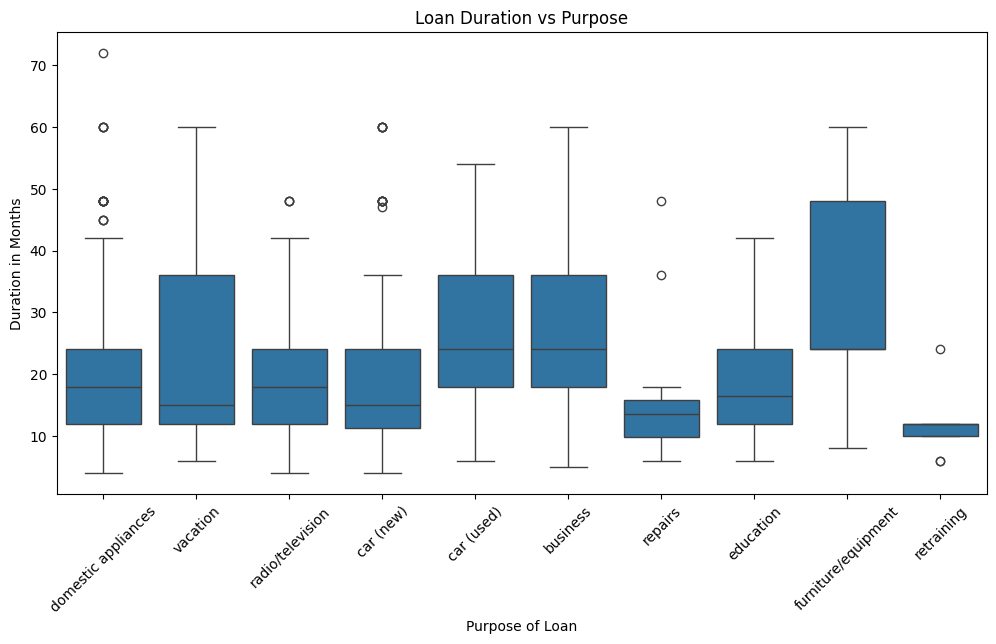

In [183]:
# visualize how the duration_in_month variable is related to the purpose

# Set up the figure size
plt.figure(figsize=(12, 6))

# Create a boxplot of 'duration_in_month' grouped by 'purpose'
sns.boxplot(x='purpose', y='duration_in_month', data=df)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add labels and title
plt.title('Loan Duration vs Purpose')
plt.xlabel('Purpose of Loan')
plt.ylabel('Duration in Months')

# Show the plot
plt.show()


In [184]:
'''
from the boxplot above, we see that the highest duration in the data history was for a loan for a
domestic appliance, the lowest value as well was for it

the smallest median duration was for retraining
for furniture/equipment about 50% spent <=25 months, the other 50% durations vary a lot between 25-60months
the smallest variation of loan durations was for retrainings (so people rend to close the bill for this purpose
more or less in similar short (~10-13 months) terms)


'''

'\nfrom the boxplot above, we see that the highest duration in the data history was for a loan for a\ndomestic appliance, the lowest value as well was for it\n\nthe smallest median duration was for retraining\nfor furniture/equipment about 50% spent <=25 months, the other 50% durations vary a lot between 25-60months\nthe smallest variation of loan durations was for retrainings (so people rend to close the bill for this purpose\nmore or less in similar short (~10-13 months) terms)\n\n\n'

In [185]:
df.credit_history.value_counts()

## no credits taken/ all credits paid back duly -  indicates that the person has either never taken a loan
# or has cleared all their debts without issues.
# the rest are clear

,count
credit_history,
existing credits paid back duly till now,530
critical account/ other credits existing (not at this bank),293
delay in paying off in the past,88
all credits at this bank paid back duly,49
no credits taken/ all credits paid back duly,40


In [186]:
df.credit_amount.describe()
# max loan was about 18424DM

,credit_amount
count,1000.000000
mean,3271.258000
std,2822.736876
min,250.000000
25%,1365.500000
50%,2319.500000
75%,3972.250000
max,18424.000000


In [188]:
df.age.describe()

# the majority (75% of the borrowers) are young or middle-aged people
# less than or equal to 42 years old, however we have people(or a person) who is old(75 yold)

,age
count,1000.000000
mean,35.546000
std,11.375469
min,19.000000
25%,27.000000
50%,33.000000
75%,42.000000
max,75.000000


In [189]:
print(len(df[df['age']==75]))
# only 2 75 yold people

2


In [190]:
df.savings.value_counts()

,count
savings,
... < 100 DM,603
unknown/ no savings account,183
100 <= ... < 500 DM,103
500 <= ... < 1000 DM,63
.. >= 1000 DM,48


In [191]:
df.present_emp_since.value_counts()
# shows the #years in their current job
## the majority has been wroking in their current job for 1-4years


,count
present_emp_since,
1 <= ... < 4 years,339
.. >= 7 years,253
4 <= ... < 7 years,174
... < 1 year,172
unemployed,62


In [192]:
df['present_emp_since'] = df['present_emp_since'].replace('.. >= 7 years', '... >= 7 years')
# for consistency

In [193]:
df.present_emp_since.value_counts()


,count
present_emp_since,
1 <= ... < 4 years,339
... >= 7 years,253
4 <= ... < 7 years,174
... < 1 year,172
unemployed,62


In [194]:
# Filter for unemployed and defaulted loans
unemployed_default = df[(df['present_emp_since'] == 'unemployed') & (df['default'] == 1)]

# Get the number of such loans
num_unemployed_default = len(unemployed_default)
print(f"Number of unemployed who defaulted: {num_unemployed_default}")

# Get the purposes of these loans
unemployed_default_purposes = unemployed_default['purpose'].value_counts()
print("\nPurposes of loans for unemployed who defaulted:")
print(unemployed_default_purposes)

# out of 62 unemployed 23 defaulted - 37%

Number of unemployed who defaulted: 23

Purposes of loans for unemployed who defaulted:
purpose
car (new)              7
radio/television       5
domestic appliances    3
business               3
car (used)             2
education              1
repairs                1
vacation               1
Name: count, dtype: int64


In [195]:
employed_default = df[(df['present_emp_since'] == '... >= 7 years') & (df['default'] == 1)]
num_unemployed_default = len(employed_default)
print(f"Number of employed who defaulted: {num_unemployed_default}")

employed_default_purposes = employed_default['purpose'].value_counts()
print("\nPurposes of loans for employed who defaulted:")
print(employed_default_purposes)

# out of 253 people working >=7 years, 64 got default - 25% (lower than the unemployed default rate of 37%)
# defaulted for new cars and for setting up businesses (but failed)

Number of employed who defaulted: 64

Purposes of loans for employed who defaulted:
purpose
car (new)              22
business               10
radio/television       10
car (used)              8
vacation                6
domestic appliances     5
furniture/equipment     2
education               1
Name: count, dtype: int64


In [196]:
# in geenral what needs have unemployed (not only defaulted unemployed)
unemployed = df[(df['present_emp_since'] == 'unemployed')]
unemployed_purposes = unemployed['purpose'].value_counts()
print("\nPurposes of loans for unemployed:")
print(unemployed_purposes)

## majority had a need of purhcasing new or used cars


Purposes of loans for unemployed:
purpose
car (new)              18
car (used)             11
radio/television       11
domestic appliances     8
business                4
furniture/equipment     4
education               3
retraining              1
repairs                 1
vacation                1
Name: count, dtype: int64


In [197]:
longer_employed = df[df['present_emp_since'] == '... >= 7 years']
longer_employed_purposes = longer_employed['purpose'].value_counts()
print("\nPurposes of loans for longer employed:")
print(longer_employed_purposes)

# longer employed borrowers want to buy doemstic appliances and NEW cars


Purposes of loans for longer employed:
purpose
domestic appliances    80
car (new)              57
radio/television       35
car (used)             34
business               22
vacation               14
education               5
furniture/equipment     4
retraining              2
Name: count, dtype: int64


In [198]:
df.installment_as_income_perc.describe()
# shows the percentage of the person's income that goes towards loan installments (monthly մայր գումար+տոկոսի մարում).
# Higher percentages might indicate financial strain or over-leverage.


,installment_as_income_perc
count,1000.000000
mean,2.973000
std,1.118715
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,4.000000


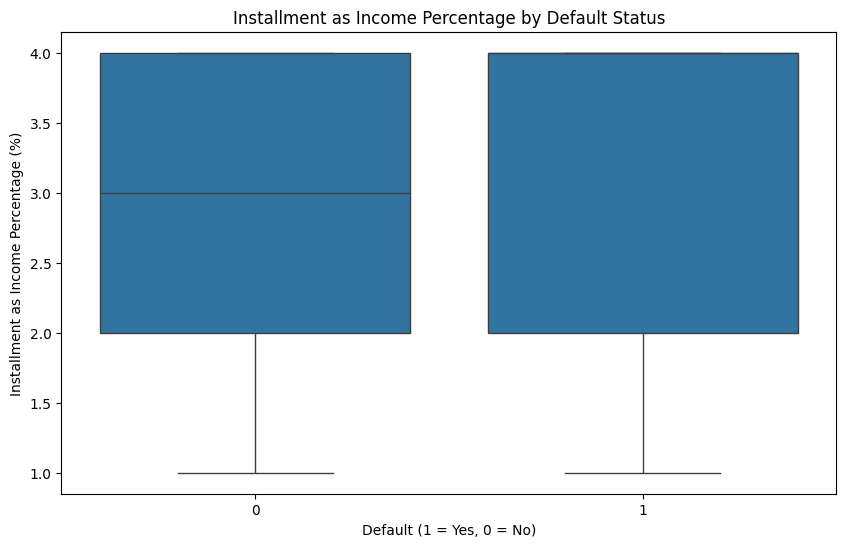

In [199]:
plt.figure(figsize=(10, 6))
# Create a boxplot: 'default' as the categorical variable and 'installment_as_income_perc' as the continuous one
sns.boxplot(x='default', y='installment_as_income_perc', data=df)

# Add title and labels
plt.title('Installment as Income Percentage by Default Status')
plt.xlabel('Default (1 = Yes, 0 = No)')
plt.ylabel('Installment as Income Percentage (%)')

# Show the plot
plt.show()

In [200]:
# Filter the DataFrame for rows where 'default' is 1
defaulted_loans = df[df['default'] == 1]

# Calculate the median 'installment_as_income_perc' for the filtered data
median_installment_perc = defaulted_loans['installment_as_income_perc'].median()

# Print the result
print(f"Median installment as income percentage for defaulted loans: {median_installment_perc}")

Median installment as income percentage for defaulted loans: 4.0


In [201]:
# so for people not defualting, the 50% pay from their income 3 or more % for the loan payments
# while for defaulted ones the percentage is 4% (the maximum allowed)- very logical

In [202]:
df.personal_status_sex.value_counts()

,count
personal_status_sex,
male : single,548
female : divorced/separated/married,310
male : married/widowed,92
male : divorced/separated,50


In [203]:
# since in our dataset, we don;t have nay other female category do simplification
df['personal_status_sex'] = df['personal_status_sex'].replace('female : divorced/separated/married', 'female')

In [204]:
df.personal_status_sex.value_counts()

# we see that single males are more keen to take loans than married men

,count
personal_status_sex,
male : single,548
female,310
male : married/widowed,92
male : divorced/separated,50


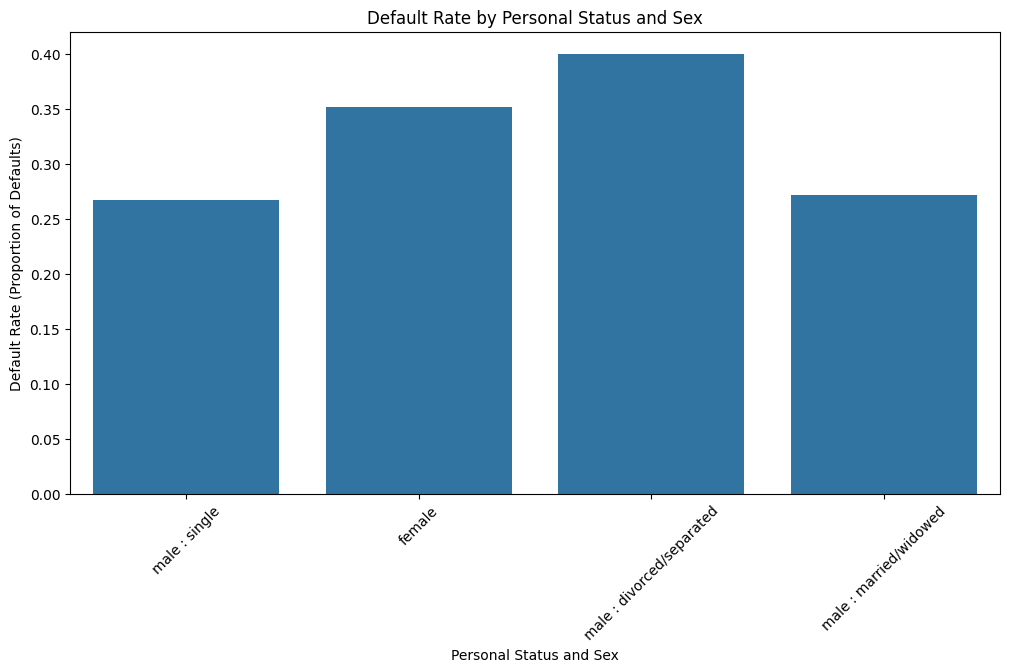

In [242]:
# Set up the figure size
plt.figure(figsize=(12, 6))

# Create a bar plot showing default rate of 1s(i.e porportion of defaults among all in that status category) by 'personal_status_sex'
sns.barplot(x='personal_status_sex', y='default', data=df, estimator=lambda x: sum(x) / len(x), errorbar=None)

# Add title and labels
plt.title('Default Rate by Personal Status and Sex')
plt.xlabel('Personal Status and Sex')
plt.ylabel('Default Rate (Proportion of Defaults)')

# Show the plot
plt.xticks(rotation=45)
plt.show()

## divorced,seerated men (depressed men)) more keen towards loans
# as females include more categories (seperated,divorced and married) then male categories, hard to conclude anything

In [206]:
df.other_debtors.value_counts()
# the absolute majority does not have a guarantee (a backup person attached to their bill)

,count
other_debtors,
none,907
guarantor,52
co-applicant,41


In [207]:
# for our convinience

df['other_debtors'] = df['other_debtors'].replace('none', 'no')

# Create a gender column
df['gender'] = df['personal_status_sex'].apply(lambda x: 'male' if x.startswith('male') else 'female')


In [208]:
df['gender'].value_counts()

,count
gender,
male,690
female,310


In [209]:
df.other_debtors.value_counts()

,count
other_debtors,
no,907
guarantor,52
co-applicant,41


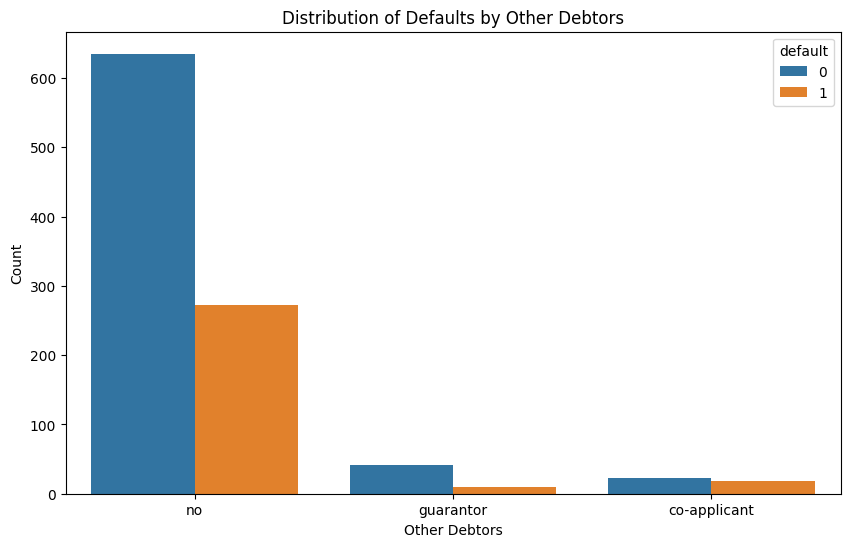

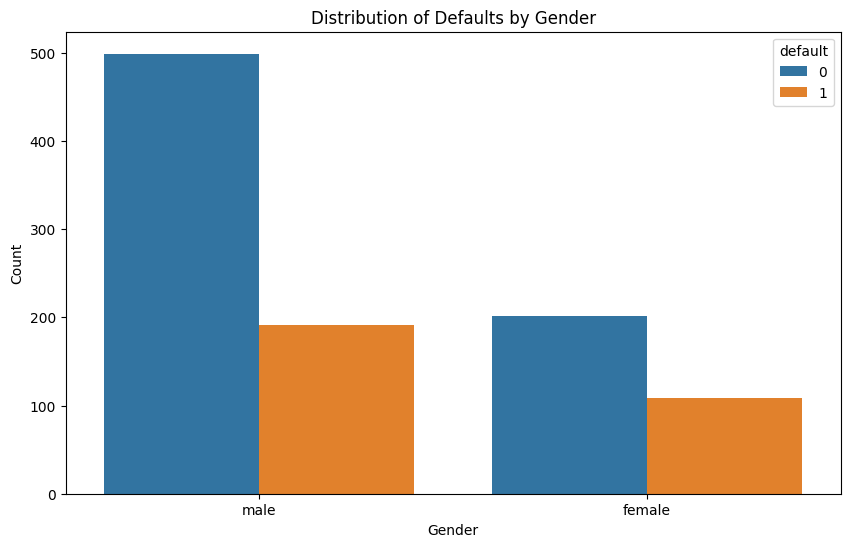

In [210]:
# Visualize the distribution of defaults  with frequencies
# a. For other debtors
plt.figure(figsize=(10, 6))
sns.countplot(x='other_debtors', hue='default', data=df)
plt.title('Distribution of Defaults by Other Debtors')
plt.xlabel('Other Debtors')
plt.ylabel('Count')
plt.show()

# b. For gender
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', hue='default', data=df)
plt.title('Distribution of Defaults by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

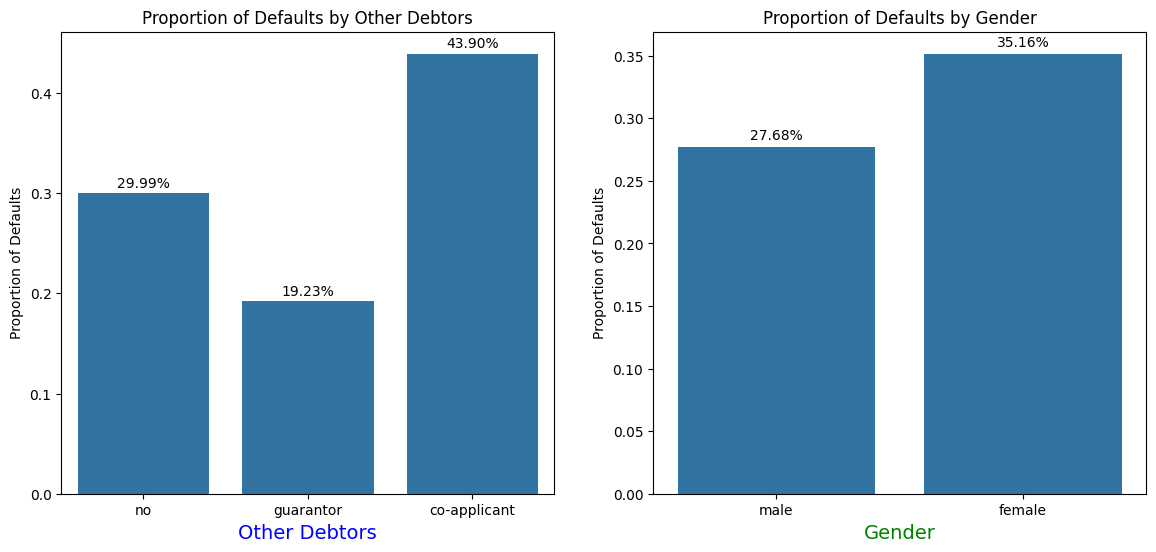

In [211]:
# Visualize the proportion of defaults for each category of 'other_debtors' for better insights/comparisons
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Calculate the proportion of defaults within each category
# and plot it using a bar plot
sns.barplot(
    x='other_debtors',
    y='default',
    data=df,
    estimator=lambda x: sum(x) / len(x),  # Calculate proportion of defaults
    errorbar=None,
    ax=axes[0]  # Assign to the first subplot
)

axes[0].set_title('Proportion of Defaults by Other Debtors')
axes[0].set_xlabel('Other Debtors', fontsize=14, color='blue')
axes[0].set_ylabel('Proportion of Defaults')


# Add percentage labels on top of the bars
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(
        p.get_x() + p.get_width() / 2.,
        height + 0.006,
        '{:1.2f}%'.format(height * 100),
        ha="center"
    )

# Subplot 2: Proportion of Defaults by Gender
sns.barplot(
    x='gender',
    y='default',
    data=df,
    estimator=lambda x: sum(x) / len(x),
    errorbar=None,
    ax=axes[1]  # Assign to the second subplot
)
axes[1].set_title('Proportion of Defaults by Gender')
# Set font size and color for x-axis title in Subplot 2
axes[1].set_xlabel('Gender', fontsize=14, color='green')
axes[1].set_ylabel('Proportion of Defaults')


# Add percentage labels on top of bars (Subplot 2)
for p in axes[1].patches:
    height = p.get_height()
    axes[1].text(
        p.get_x() + p.get_width() / 2.,
        height + 0.006,
        '{:1.2f}%'.format(height * 100),
        ha="center"
    )


# Adjust layout to prevent overlapping
# plt.tight_layout()
plt.show()



In [212]:

df.present_res_since.value_counts()
# The number of years the person has lived at their current residence.
# Longer residence times often indicate stability, which can affect creditworthiness.


,count
present_res_since,
4,413
2,308
3,149
1,130


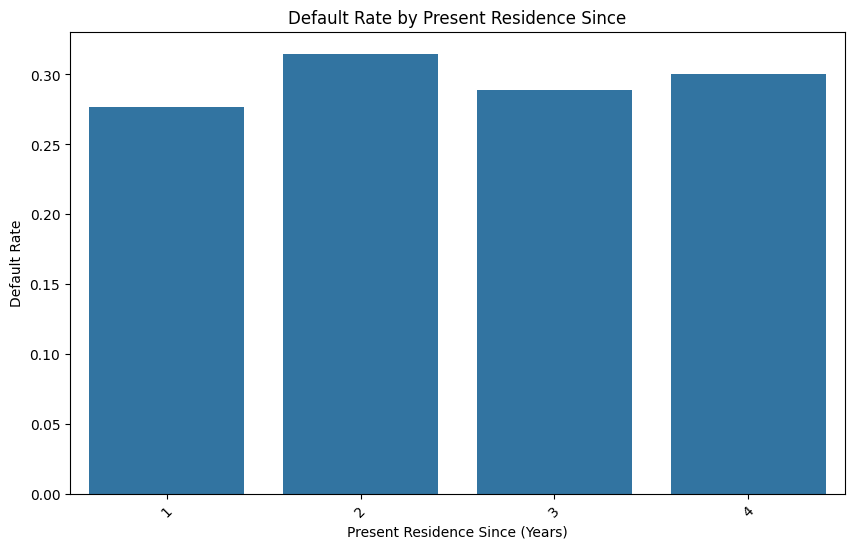

In [213]:

plt.figure(figsize=(10, 6))
sns.barplot(x='present_res_since', y='default', data=df, estimator=lambda x: sum(x) / len(x), errorbar=None)
plt.title('Default Rate by Present Residence Since')
plt.xlabel('Present Residence Since (Years)')
plt.ylabel('Default Rate')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

# more or less the same picture not depending on the number of years spent in the current house/home

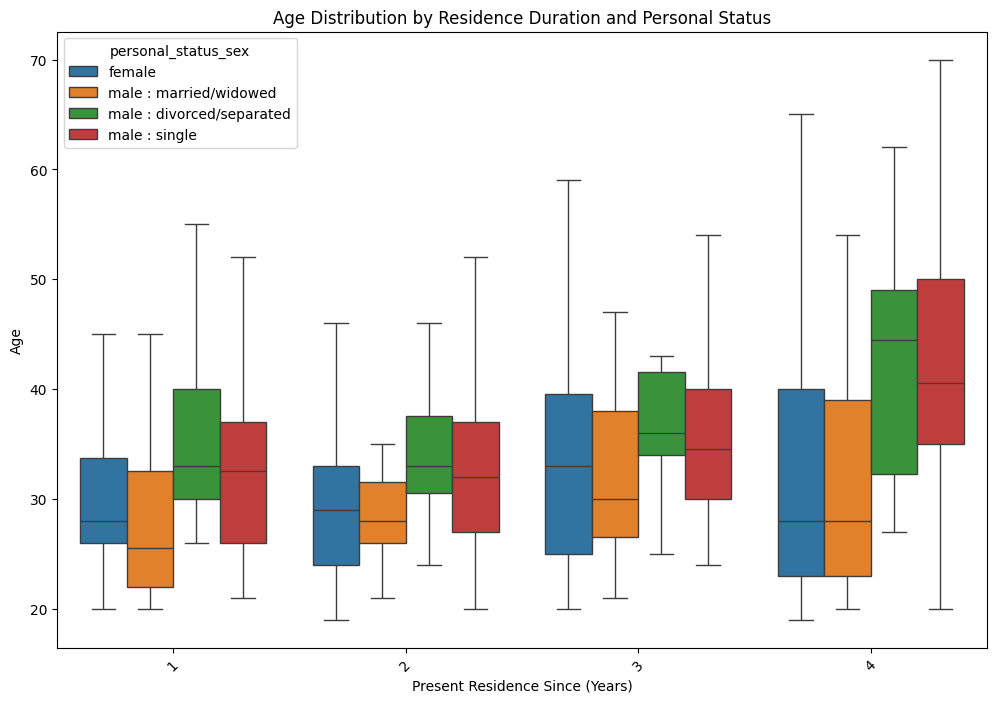

In [214]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='present_res_since', y='age', hue='personal_status_sex', data=df, showfliers=False)
plt.title('Age Distribution by Residence Duration and Personal Status')
plt.xlabel('Present Residence Since (Years)')
plt.ylabel('Age')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()


## we see that among single and divorced/seperated men, older people tend to live longer in their current residence ( based on medians )
## particularly, the maximum age increases as the #years spent at the current location aslo increases for all personal status categ-s


In [215]:
df.property.value_counts()

,count
property,
"if not A121/A122 : car or other, not in attribute 6",332
real estate,282
if not A121 : building society savings agreement/ life insurance,232
unknown / no property,154


In [216]:
df['property'] = df['property'].replace({
    'if not A121/A122 : car or other, not in attribute 6': 'car/other',
    'if not A121 : building society savings agreement/ life insurance': 'savings/life insurance',
    'unknown / no property': 'unknown/no property'
})

In [217]:
df.property.value_counts()
# the majority owns a car

,count
property,
car/other,332
real estate,282
savings/life insurance,232
unknown/no property,154


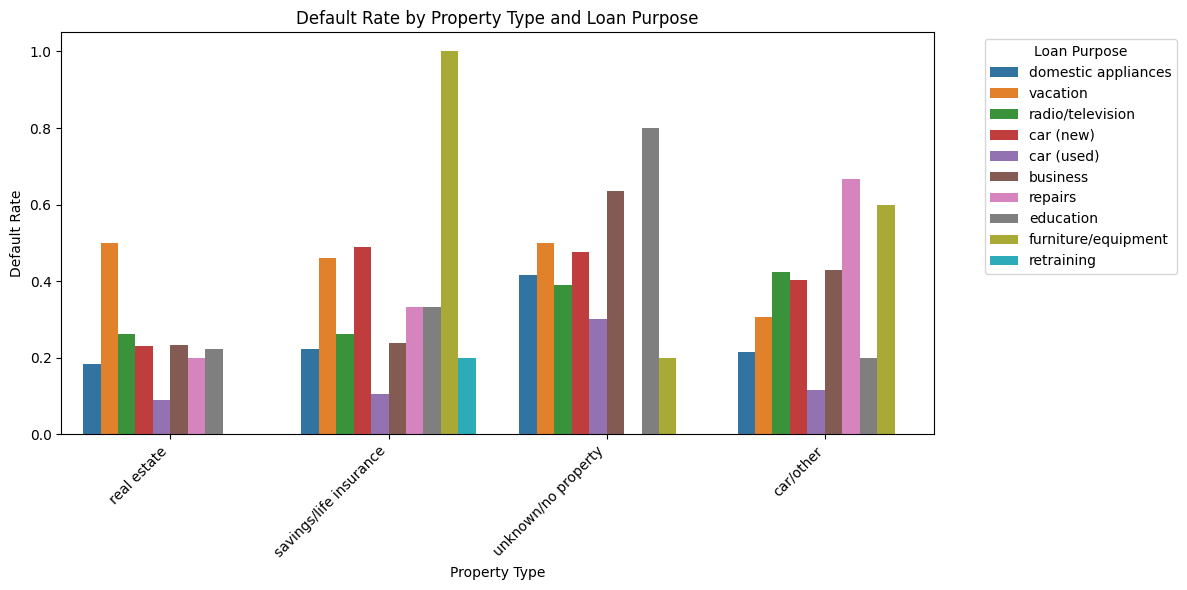

In [218]:

# Create the stacked bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='property', y='default', hue='purpose', data=df, estimator=lambda x: sum(x) / len(x), errorbar=None)


plt.title('Default Rate by Property Type and Loan Purpose')
plt.xlabel('Property Type')
plt.ylabel('Default Rate')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Loan Purpose', bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside the plot
plt.tight_layout()
plt.show()


# we see that people having saving aggreements and/or life insurance aggreement take loans more for furniture or equaiplement
# on the oter hand, people having real estates, for example their own homes, do not need laons for furniture that much,
# but borrow money for vacations
# logically, people owning cars, borrow money for repairs (car expenses, equipments)
# and people not having any property yet spend moeny on education (pretty logical investment at that stage)

In [219]:
df.other_installment_plans.value_counts()

# indicates whether the loan applicant has other installment plans or ongoing loans with institutions besides the one they're
# currently applying to.

# 'none': The applicant has no other installment plans.
# 'bank': The applicant has other installment plans with a bank. (such as aother loan)
# 'stores': The applicant has other installment plans with stores

,count
other_installment_plans,
none,814
bank,139
stores,47


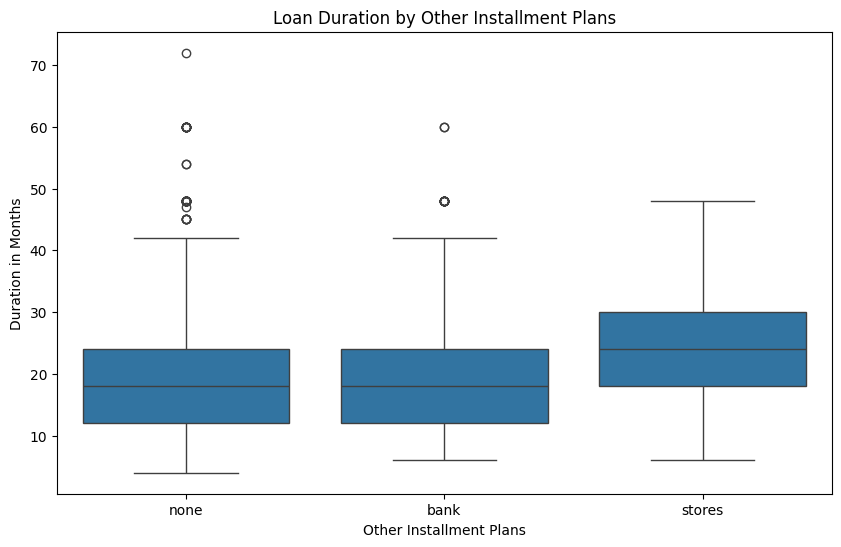

In [220]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='other_installment_plans', y='duration_in_month', data=df)
plt.title('Loan Duration by Other Installment Plans')
plt.xlabel('Other Installment Plans')
plt.ylabel('Duration in Months')
plt.show()

# loans from stores (the upper 50%) last longer than additional (secondary) loans from banks
# (maybe banks enforce more on faster payments and closing the loan and knowing about the first loan form another bank,
# for the second loan the bank deos not give too much money which is easier to pay and end than store loans,
# that's why maybe bank secondary loans have shorter duratiosn)

# but otherwise, for single loans, the upper values of durations are higher (from ~~45-70 months)

In [221]:
df.housing.value_counts()

,count
housing,
own,713
rent,179
for free,108


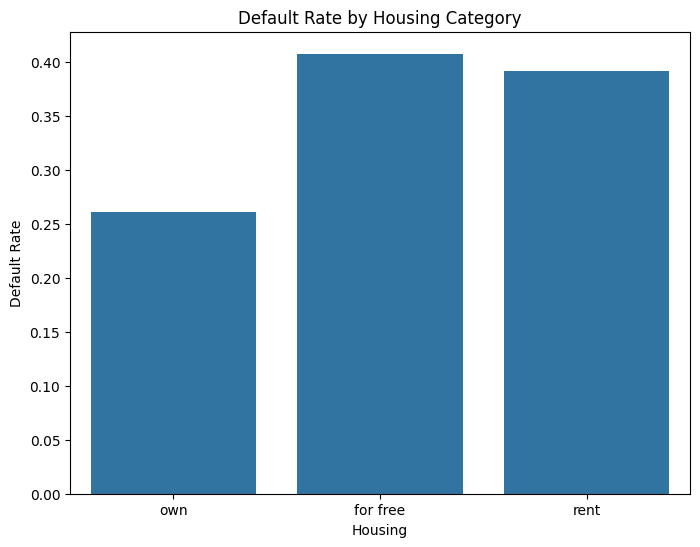

In [222]:
plt.figure(figsize=(8, 6))
sns.barplot(x='housing', y='default', data=df, estimator=lambda x: sum(x) / len(x), errorbar=None)
plt.title('Default Rate by Housing Category')
plt.xlabel('Housing')
plt.ylabel('Default Rate')
plt.show()
# people with their own houses tend to go default less than people living for rent or free in houses that are not theirs - logical

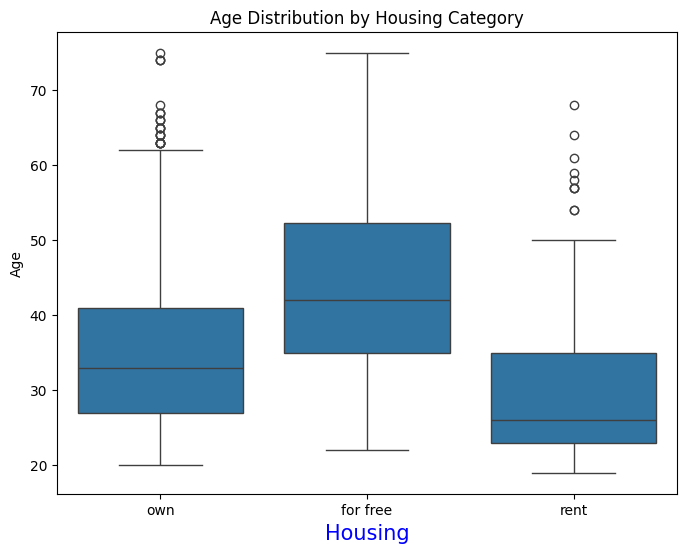

In [223]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='housing', y='age', data=df)
plt.title('Age Distribution by Housing Category')
plt.xlabel('Housing',fontsize=15, color="blue")
plt.ylabel('Age')
plt.show()

# I thought people owning houses would be much older since tehy need to have earned more for buying a property
# but only the upper few loan cases belong to older - house owning people
# fro the rest, borrowers with free living housing (maybe ծերանոցում են և վարկ են վերցրել),
#  are older than people living in their properties or for rent

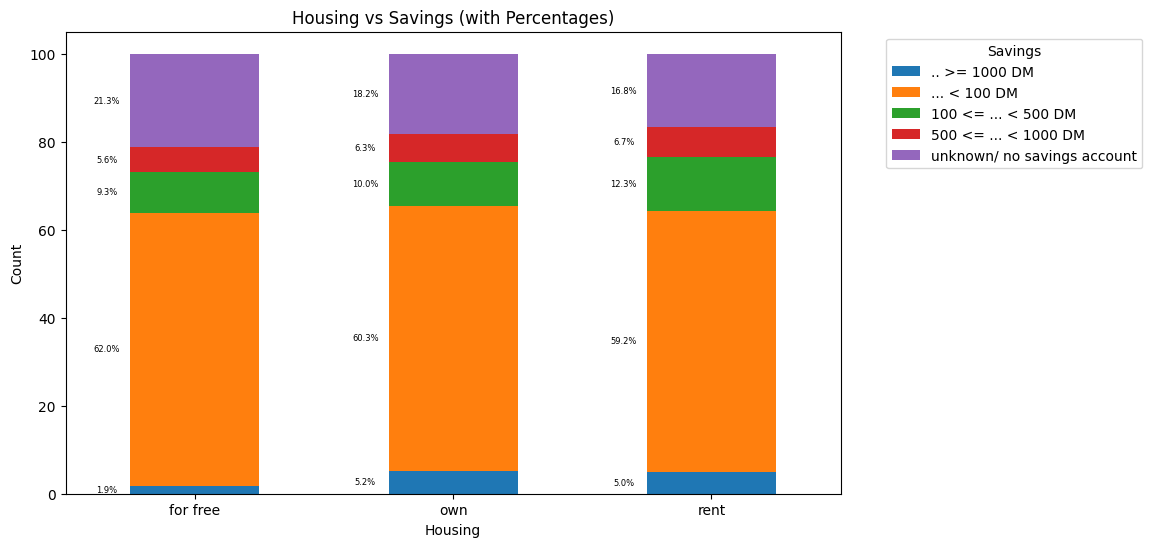

In [224]:
# Create a cross-tabulation of housing and savings
housing_savings = pd.crosstab(df['housing'], df['savings'])

# Calculate percentages for each savings category within each housing category
housing_savings_perc = housing_savings.div(housing_savings.sum(axis=1), axis=0) * 100

# Create the stacked bar plot with percentages
ax = housing_savings_perc.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Housing vs Savings (with Percentages)')
plt.xlabel('Housing')
plt.ylabel('Count') # changed to count
plt.legend(title='Savings', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

# Add percentage labels to the left of the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:  # Only display labels if height is greater than 0
        ax.text(x - 0.09,
                y + height/2,
                '{:.1f}%'.format(height),
                ha='center',
                va='center',
                color='black',
                fontsize = 6)  # Set text color to white for better visibility

plt.show()

# we see that people living for free, are more without any saving accounts than the rest of teh housing types
# people with renting and own houses have more higher amount savings than the free living ones
# approximately the same proportion of low-amount savings (less than 100DM) among all housing types

In [225]:
housing_savings

savings,.. >= 1000 DM,... < 100 DM,100 <= ... < 500 DM,500 <= ... < 1000 DM,unknown/ no savings account
housing,,,,,
for free,2,67,10,6,23
own,37,430,71,45,130
rent,9,106,22,12,30


In [226]:
housing_savings_perc

savings,.. >= 1000 DM,... < 100 DM,100 <= ... < 500 DM,500 <= ... < 1000 DM,unknown/ no savings account
housing,,,,,
for free,1.851852,62.037037,9.259259,5.555556,21.296296
own,5.189341,60.308555,9.957924,6.311360,18.232819
rent,5.027933,59.217877,12.290503,6.703911,16.759777


In [227]:
# credits_this_bank: the number of credit products or loans the person has with this particular bank.
# A higher number of loans with a bank might indicate trust and a longer relationship.

# we will relate with:
# duration_in_month: Loan duration could potentially be influenced by the trust and relationship built over multiple
#    loans with the same bank. Longer relationships might lead to more flexible loan terms and longer durations.
# credit_amount: The amount of credit granted might also be related to the number of previous loans with the bank.
#    Established trust could lead to higher credit limits.
# default: Exploring the relationship with default rates could reveal if customers with more credit products at the bank are less likely
#    to default, potentially due to a stronger relationship or better risk assessment by the bank.

df.credits_this_bank.value_counts()
# the majority has a single loan with this bank


,count
credits_this_bank,
1,633
2,333
3,28
4,6


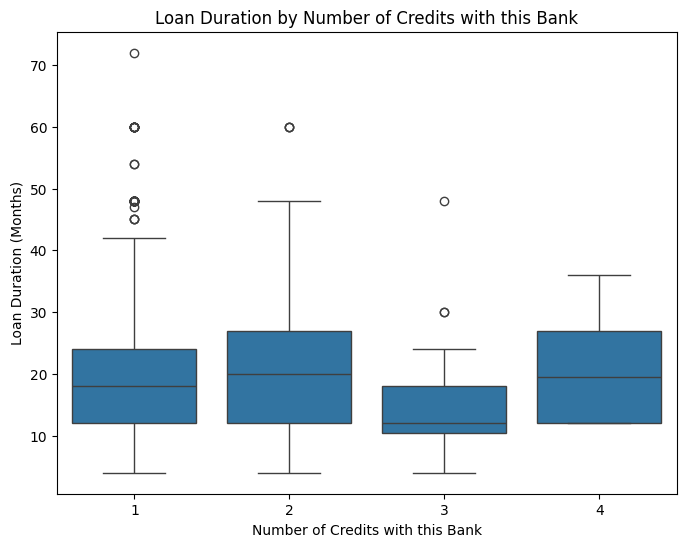

In [228]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='credits_this_bank', y='duration_in_month', data=df)
plt.title('Loan Duration by Number of Credits with this Bank')
plt.xlabel('Number of Credits with this Bank')
plt.ylabel('Loan Duration (Months)')
plt.show()

# not much difference in the middle 50% of the duration values among people havign 4 loans and 2 loans
# , people with 1 loan even have longer durations than people with 4 loans at the same bank, so no insight from this

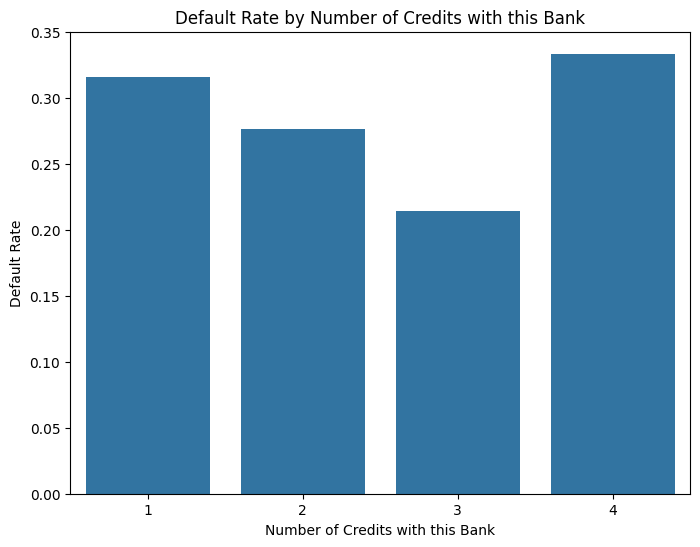

In [229]:
plt.figure(figsize=(8, 6))
sns.barplot(x='credits_this_bank', y='default', data=df, estimator=lambda x: sum(x) / len(x), errorbar=None)
plt.title('Default Rate by Number of Credits with this Bank')
plt.xlabel('Number of Credits with this Bank')
plt.ylabel('Default Rate')
plt.show()

# we see even the counter insight, people with more 4 loans got many loans but are nto that much trusty, they have more defaulting rate

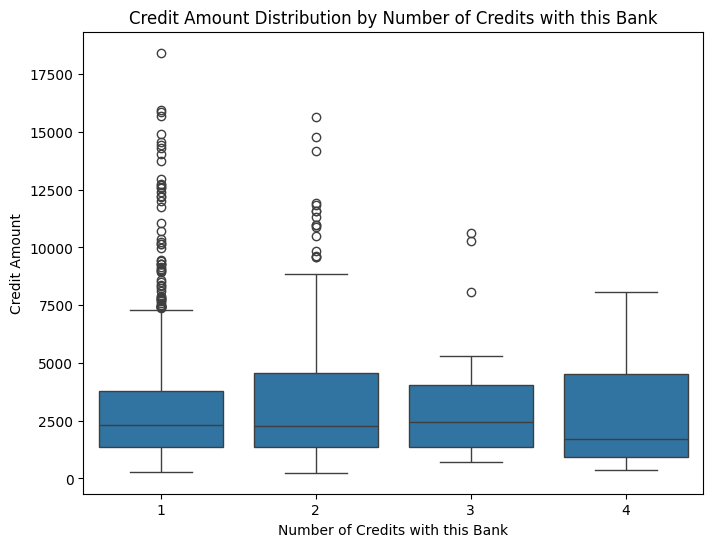

In [230]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='credits_this_bank', y='credit_amount', data=df)
plt.title('Credit Amount Distribution by Number of Credits with this Bank')
plt.xlabel('Number of Credits with this Bank')
plt.ylabel('Credit Amount')
plt.show()
# again we see that the middle vduration values fr loan 4 and 2 are similar and larger than for loan amount=1 or 3
# i.e. people get more diverse amounts, but these amoutns are not significantly larger than for borrowers with 1 loan for example
# in fact people with 1 loan, have many outlisers with too large loan amounts

# so we see that probably credits_this_bank is not related with trust that much for this bank

In [231]:
df.job.value_counts()

,count
job,
skilled employee / official,630
unskilled - resident,200
management/ self-employed/ highly qualified employee/ officer,148
unemployed/ unskilled - non-resident,22


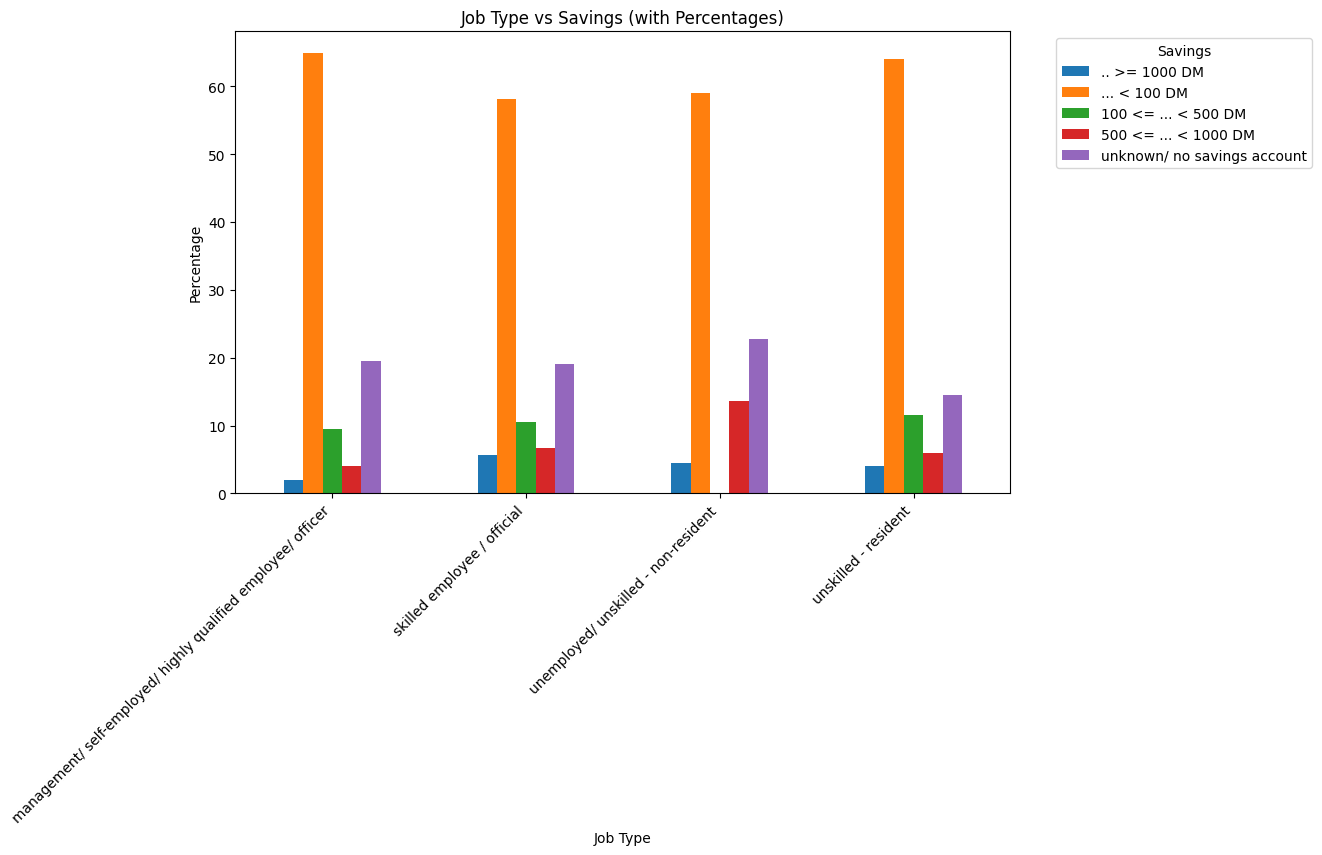

In [232]:
# Create a cross-tabulation of present_emp_since and savings
job_savings = pd.crosstab(df['job'], df['savings'])

# Calculate percentages for each savings category within each job type category
job_savings_perc = job_savings.div(job_savings.sum(axis=1), axis=0) * 100

# Create the grouped bar chart with percentages
job_savings_perc.plot(kind='bar', figsize=(10, 6))
plt.title('Job Type vs Savings (with Percentages)')
plt.xlabel('Job Type')
plt.ylabel('Percentage') # Updated Y-Axis label
plt.legend(title='Savings', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

# since we plotted the relative percentages, we can easily compare the bar lengths

## we see that more or less the <100DM saving is pretty common among all job categories
# but for skilled employees/officials the highest-amount savings (>1000DM) comprise a more proportion than for the rest
# unkilled non residents/unemployed do not have savings between 100 and 500DM but have the highest 500-1000DM,
# probably they moved to this country with large amount of saving but did not acquire a job or skillset in this country yet

In [233]:
# people_under_maintenance: the number of people who are financially dependent on this person
#  (e.g., children, elderly relatives). This could affect the person’s ability to repay a loan due to
#  additional financial responsibilities.

df.people_under_maintenance.value_counts()

,count
people_under_maintenance,
1,845
2,155


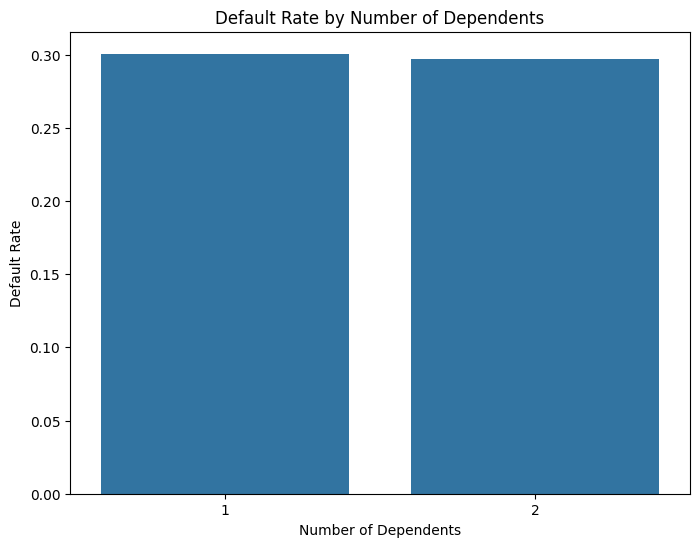

In [234]:
# Create a bar plot showing the default rate by number of dependents
plt.figure(figsize=(8, 6))
sns.barplot(x='people_under_maintenance', y='default', data=df, estimator=lambda x: sum(x) / len(x), errorbar=None)
plt.title('Default Rate by Number of Dependents')
plt.xlabel('Number of Dependents')
plt.ylabel('Default Rate')
plt.show()
# not an interesting picture as our borrowers do not have many varying number of dependent people on them
# (people with large families seem not to be a part of this dataset)

In [235]:
# telephone:Whether the person has a telephone or not. This could be a proxy for socioeconomic status,
#  though it's somewhat less common in modern times.

df.telephone.value_counts()

# interesting to have nones, I think this stands for missing telephones or non-active phone numebrs
# since telephone is pretty common nowadays independetn of the socioeconomic status


,count
telephone,
none,596
"yes, registered under the customers name",404


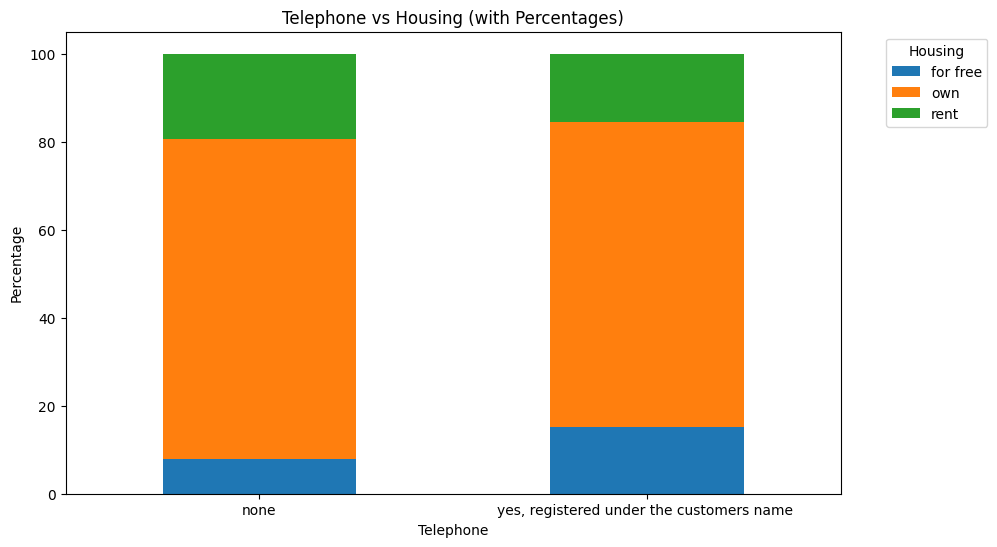

In [236]:
# Create a cross-tabulation of telephone and housing
telephone_housing = pd.crosstab(df['telephone'], df['housing'])

# Calculate percentages for each housing category within each telephone category
telephone_housing_perc = telephone_housing.div(telephone_housing.sum(axis=1), axis=0) * 100

# Create the stacked bar plot with percentages
ax = telephone_housing_perc.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Telephone vs Housing (with Percentages)')
plt.xlabel('Telephone')
plt.ylabel('Percentage')
plt.legend(title='Housing', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

# people with non consistent/non-active telephone numebrs tend to live in rent houses more than with active phoen numbers
# maybe becasue they give the rented house's phone number which got changed after they moved
# people livign for free have more active phne numbers than non-active phone numbers, as maybe they live in a constant enironemt
# and do not change phone numbers (orinak ceranoc again)

In [237]:
# foreign_worker: whether the person is a foreign worker (binary variable, likely yes or no).
# This can reflect employment status and residence factors that may impact creditworthiness.

df.foreign_worker.value_counts()

,count
foreign_worker,
yes,963
no,37


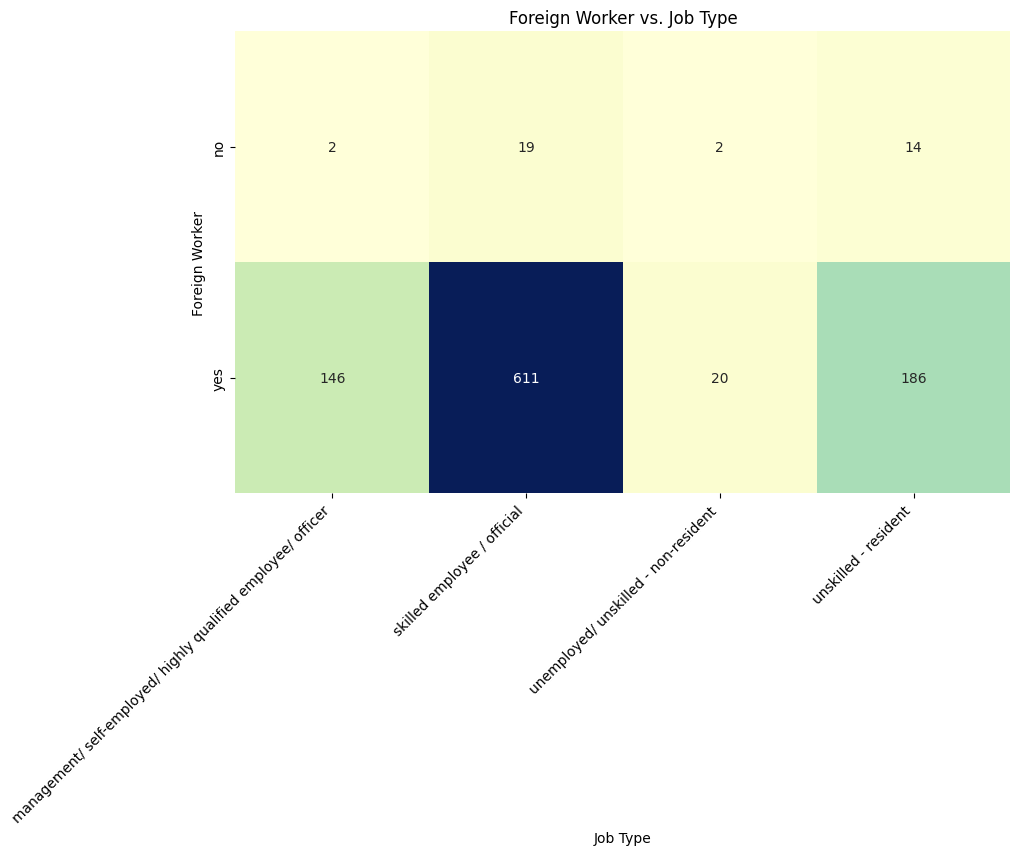

In [238]:
# Create a cross-tabulation of foreign_worker and job
foreign_worker_job = pd.crosstab(df['foreign_worker'], df['job'])

# Create a mosaic plot
plt.figure(figsize=(10, 6))
mosaic = sns.heatmap(foreign_worker_job, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title('Foreign Worker vs. Job Type')
plt.xlabel('Job Type')
plt.ylabel('Foreign Worker')
plt.xticks(rotation=45, ha='right')
plt.show()


## the majority of skilled employees are foreignors, and in general, for all type of jobs, foreign labour is the majority

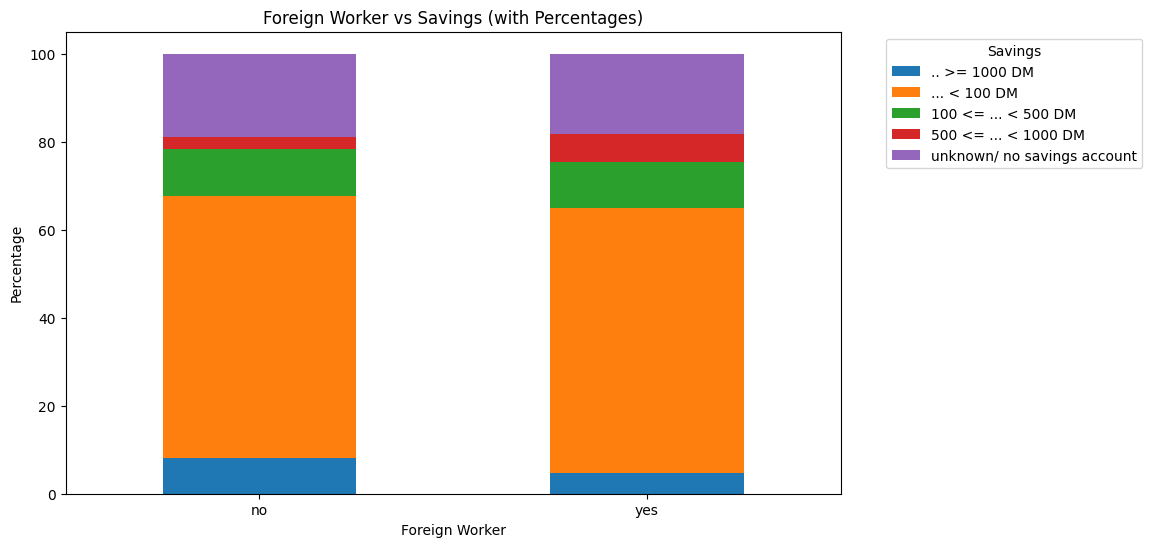

In [239]:
# Create a cross-tabulation of foreign_worker and savings
foreign_worker_savings = pd.crosstab(df['foreign_worker'], df['savings'])

# Calculate percentages for each savings category within each foreign_worker category
foreign_worker_savings_perc = foreign_worker_savings.div(foreign_worker_savings.sum(axis=1), axis=0) * 100

# Create the stacked bar plot with percentages
ax = foreign_worker_savings_perc.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Foreign Worker vs Savings (with Percentages)')
plt.xlabel('Foreign Worker')
plt.ylabel('Percentage')
plt.legend(title='Savings', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.show()

# foreignors differ from non-foreignors just by gaving more 100-500DM savings and less <100DMs, but local people have
# a larger proportion of veyr rich people >1000DM than foreignors

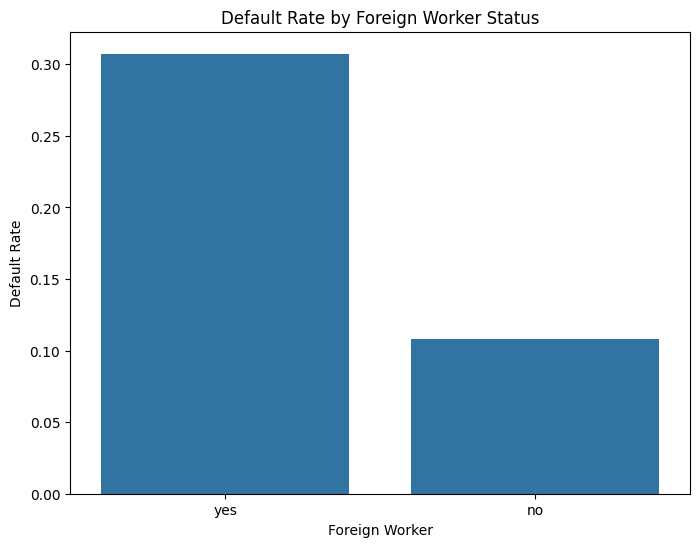

In [240]:
plt.figure(figsize=(8, 6))
sns.barplot(x='foreign_worker', y='default', data=df, estimator=lambda x: sum(x) / len(x), errorbar=None)
plt.title('Default Rate by Foreign Worker Status')
plt.xlabel('Foreign Worker')
plt.ylabel('Default Rate')
plt.show()

# intuitively, foreignors have more defaulting that locals who have a higehr sense of responsibility and resppect for the laws

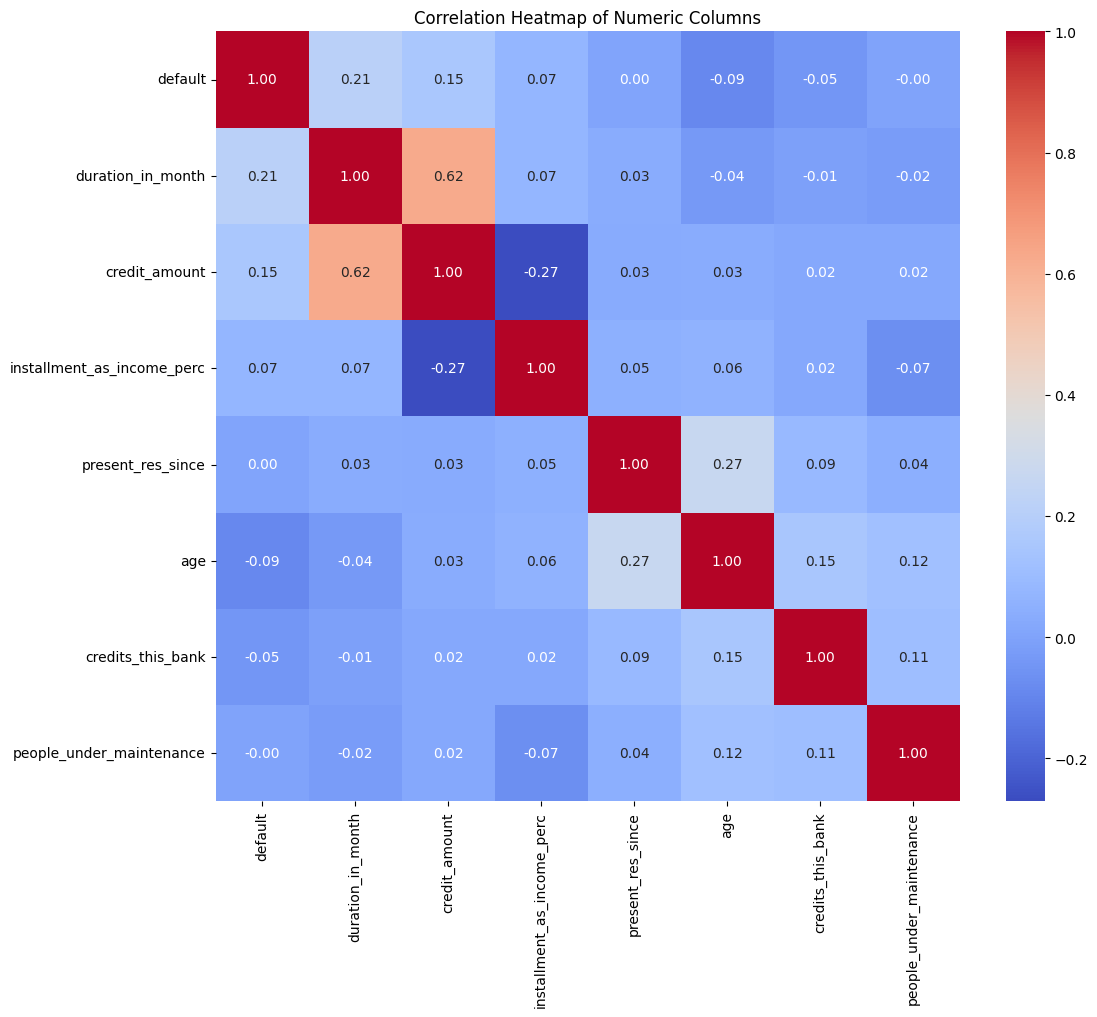

In [241]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix for numeric columns
correlation_matrix = numeric_df.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

# among numerical features, we can say only credit_amount is highlypositievly correlated with duration_in_month, pretty logical
# as in order to close  ahigher bill, more months are required

# and a slight negtaive corr with installment and credit_amoutn, as the պահումները աշխատավարձից increase, credit_amount tends to be smaller
# as higehr percentage of bill paymnet in a salalry  menas the person has a smaller salary and the bank would provide
# a less credit amoutn for this type of person

### **Thank you !!!**